# Customer Segmentation Project: Mall Customers

In this notebook we will Segment mall customers into groups based on *Annual Income* and *Spending Score* using clustering algorithms.  
We’ll apply **K-Means** (main method) and try **DBSCAN** as a bonus.  






#  Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score


#  Load Dataset


In [2]:
df = pd.read_csv('Mall_Customers.csv')

print("First 5 rows:")
print(df.head())



First 5 rows:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


#  Data Exploration

In [3]:
print("\nData Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nDescriptive Statistics:")
print(df.describe())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

Missing Values:
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Descriptive Statistics:
       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.26472

In [4]:
# ensure the expected columns exist
expected = ['Annual Income (k$)', 'Spending Score (1-100)']
for c in expected:
    if c not in df.columns:
        raise KeyError(f"Column missing: {c}")

X = df[expected].copy()
print("\nSummary statistics:")
print(X.describe().round(2))


Summary statistics:
       Annual Income (k$)  Spending Score (1-100)
count              200.00                  200.00
mean                60.56                   50.20
std                 26.26                   25.82
min                 15.00                    1.00
25%                 41.50                   34.75
50%                 61.50                   50.00
75%                 78.00                   73.00
max                137.00                   99.00


#  Data Visualization
scatter plot , customers by Income & Spending

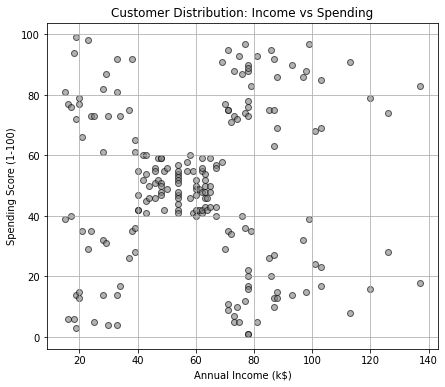

In [5]:
plt.figure(figsize=(7,6))
plt.scatter(df['Annual Income (k$)'], df['Spending Score (1-100)'], c='gray', alpha=0.6, edgecolor='k')
plt.title("Customer Distribution: Income vs Spending")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.grid(True)
plt.show()


#  Data Preprocessing
Clustering is distance-based, so scaling is essential.  
We use **StandardScaler** to normalise the two features.  

We also apply **PCA** for dimensionality reduction, but since we already have 2 features, PCA here just rotates the axes — useful for consistent plotting.  


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA (2D) - useful for plotting and future extensions
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)   # with 2 features this is basically a rotation


##  Finding Optimal k (K-Means)
We test different values of **k** and evaluate using:
- **Elbow Method** (inertia vs k)  
- **Silhouette Score** (higher = better cluster separation)  

From the plots, the optimal number of clusters is around **k=5** (silhouette suggests this).  


In [7]:
ks = list(range(2, 11))
inertias = []
silhouettes = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    # silhouette requires at least 2 clusters and < n_samples
    silhouettes.append(silhouette_score(X_scaled, labels))


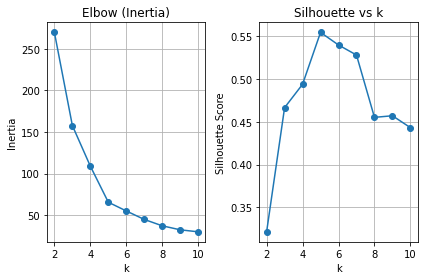

Best k by silhouette: 5


In [8]:
plt.subplot(1,2,1)
plt.plot(ks, inertias, marker='o')
plt.title('Elbow (Inertia)')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(ks, silhouettes, marker='o')
plt.title('Silhouette vs k')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

best_k = ks[int(np.argmax(silhouettes))]
print(f"Best k by silhouette: {best_k}")


#  Model
We fit KMeans with the chosen number of clusters.  
Evaluation metrics:  
- **Silhouette Score**: measures cluster separation  
- **Davies-Bouldin Score**: lower = better  
- **Calinski-Harabasz Score**: higher = better  


In [9]:
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
k_labels = kmeans.fit_predict(X_scaled)

df['KMeans_Cluster'] = k_labels

# metrics for KMeans
k_sil = silhouette_score(X_scaled, k_labels)
k_db = davies_bouldin_score(X_scaled, k_labels)
k_ch = calinski_harabasz_score(X_scaled, k_labels)
print(f"KMeans metrics — Silhouette: {k_sil:.3f}, Davies-Bouldin: {k_db:.3f}, Calinski-Harabasz: {k_ch:.1f}")


KMeans metrics — Silhouette: 0.555, Davies-Bouldin: 0.572, Calinski-Harabasz: 248.6


### Plot K-Means clusters (2D)


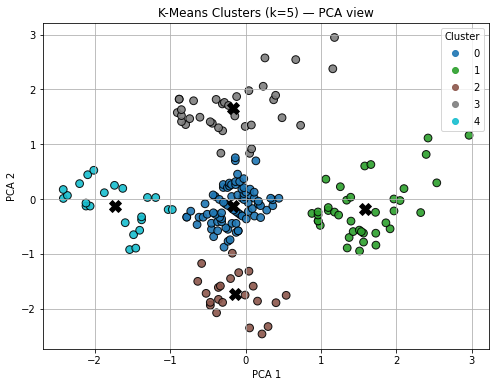

In [10]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=k_labels, cmap='tab10', s=60, edgecolor='k', alpha=0.9)
centers_pca = pca.transform(kmeans.cluster_centers_)  # map centres to PCA space
plt.scatter(centers_pca[:,0], centers_pca[:,1], c='black', s=140, marker='X', label='centroids')
plt.title(f'K-Means Clusters (k={best_k}) — PCA view')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(*scatter.legend_elements(), title='Cluster')
plt.grid(True)
plt.show()

### Cluster summary
average income & spending per KMeans cluster


In [11]:
summary = df.groupby('KMeans_Cluster')[expected].mean().round(2)
counts = df.groupby('KMeans_Cluster').size().rename('count')
cluster_summary = pd.concat([counts, summary], axis=1).reset_index().rename(columns={'KMeans_Cluster':'cluster'})


In [12]:
# Helpful quick interpretation column
def describe_row(row):
    inc = row['Annual Income (k$)']
    spend = row['Spending Score (1-100)']
    if inc >= df['Annual Income (k$)'].mean() and spend >= df['Spending Score (1-100)'].mean():
        return 'High income, High spending'
    if inc >= df['Annual Income (k$)'].mean() and spend < df['Spending Score (1-100)'].mean():
        return 'High income, Low spending'
    if inc < df['Annual Income (k$)'].mean() and spend >= df['Spending Score (1-100)'].mean():
        return 'Low income, High spending'
    return 'Low income, Low spending'

cluster_summary['label'] = cluster_summary.apply(describe_row, axis=1)

print("\nCluster summary with simple labels:") 
print(cluster_summary[['cluster','count','Annual Income (k$)','Spending Score (1-100)','label']])



Cluster summary with simple labels:
   cluster  count  Annual Income (k$)  Spending Score (1-100)  \
0        0     81               55.30                   49.52   
1        1     39               86.54                   82.13   
2        2     22               25.73                   79.36   
3        3     35               88.20                   17.11   
4        4     23               26.30                   20.91   

                        label  
0    Low income, Low spending  
1  High income, High spending  
2   Low income, High spending  
3   High income, Low spending  
4    Low income, Low spending  


#  Hyperparameter Tuning
DBSCAN: quick grid search over eps and min_samples (small grid)


In [13]:
def safe_metrics(Xarr, labels):
    unique = np.unique(labels)
    # valid silhouette if between 2 and n_samples-1 unique labels
    if len(unique) < 2 or len(unique) >= len(Xarr):
        return np.nan, np.nan, np.nan
    return (silhouette_score(Xarr, labels),
            davies_bouldin_score(Xarr, labels),
            calinski_harabasz_score(Xarr, labels))

eps_list = [0.3, 0.5, 0.8, 1.0, 1.2]
min_samples_list = [3, 5, 7, 10]
rows = []
for eps in eps_list:
    for ms in min_samples_list:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_scaled)
        sil, dbb, ch = safe_metrics(X_scaled, labels)
        rows.append({'eps': eps, 'min_samples': ms, 'silhouette': sil, 'db': dbb, 'ch': ch,
                     'n_clusters': len(set(labels) - {-1}), 'n_noise': list(labels).count(-1)})

dbscan_results = pd.DataFrame(rows).sort_values('silhouette', ascending=False).reset_index(drop=True)
print("\nDBSCAN grid results (top 5):")
print(dbscan_results.head(5))



DBSCAN grid results (top 5):
   eps  min_samples  silhouette        db          ch  n_clusters  n_noise
0  0.8           10    0.424827  0.816827   16.012286           1        4
1  0.3            3    0.413619  0.850568  105.098493           9       14
2  0.8            7    0.407154  0.491674    8.923726           1        2
3  0.5           10    0.406405  1.913685   62.649643           4       21
4  0.5            3    0.356602  0.795030   61.239861           2        7


Best DBSCAN params by silhouette: eps=0.8, min_samples=10
DBSCAN metrics — Silhouette: 0.4248274189039687, Davies-Bouldin: 0.8168269321334699, Calinski-Harabasz: 16.012285768743656


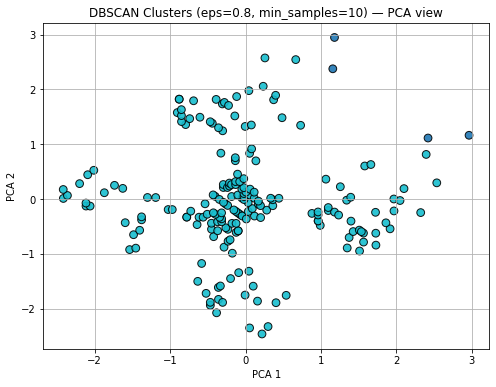


DBSCAN cluster means (excluding noise):
    count Annual Income (k$) Spending Score (1-100)
-1      4                  -                      -
 0    196              59.11                  50.19


In [14]:
# choose best by silhouette (ignore NaNs)
best_dbscan_row = dbscan_results.dropna(subset=['silhouette']).head(1)
if not best_dbscan_row.empty:
    best_eps = float(best_dbscan_row.loc[0,'eps'])
    best_ms = int(best_dbscan_row.loc[0,'min_samples'])
    print(f"Best DBSCAN params by silhouette: eps={best_eps}, min_samples={best_ms}")
    db_final = DBSCAN(eps=best_eps, min_samples=best_ms)
    db_labels = db_final.fit_predict(X_scaled)
    df['DBSCAN_Cluster'] = db_labels
    
    # metrics
    db_s, db_db, db_ch = safe_metrics(X_scaled, db_labels)
    print(f"DBSCAN metrics — Silhouette: {db_s}, Davies-Bouldin: {db_db}, Calinski-Harabasz: {db_ch}")
    
    # plot DBSCAN clusters (PCA)
    plt.figure(figsize=(8,6))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=db_labels, cmap='tab10', s=60, edgecolor='k', alpha=0.9)
    plt.title(f'DBSCAN Clusters (eps={best_eps}, min_samples={best_ms}) — PCA view')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.grid(True)
    plt.show()
    # DBSCAN summary (exclude noise = -1)
    db_summary = df[df['DBSCAN_Cluster'] != -1].groupby('DBSCAN_Cluster')[expected].mean().round(2)
    db_counts = df['DBSCAN_Cluster'].value_counts().sort_index()
    print("\nDBSCAN cluster means (excluding noise):")
    print(pd.concat([db_counts, db_summary], axis=1).rename(columns={'DBSCAN_Cluster':'count'}).fillna('-'))
else:
    print("No valid DBSCAN clustering found in given grid (silhouette NaN for all).")


In [15]:
print("\nDone. You now have:")
print("- df with 'KMeans_Cluster' (labels 0..k-1)")
print("- cluster_summary table (mean income & spending per cluster)")
print("- optional 'DBSCAN_Cluster' if DBSCAN produced clusters (noise = -1).")



Done. You now have:
- df with 'KMeans_Cluster' (labels 0..k-1)
- cluster_summary table (mean income & spending per cluster)
- optional 'DBSCAN_Cluster' if DBSCAN produced clusters (noise = -1).


In [16]:
# evaluation
def evaluate_clustering(X, labels):
    if len(set(labels)) < 2:
        return None, None, None
    sil = silhouette_score(X, labels)
    db = davies_bouldin_score(X, labels)
    ch = calinski_harabasz_score(X, labels)
    return sil, db, ch

In [17]:
kmeans_eval = evaluate_clustering(X_scaled, k_labels)
print(f"KMeans evaluation — Silhouette: {kmeans_eval[0]}, Davies-Bouldin: {kmeans_eval[1]}, Calinski-Harabasz: {kmeans_eval[2]}")


KMeans evaluation — Silhouette: 0.5546571631111091, Davies-Bouldin: 0.5722356162263351, Calinski-Harabasz: 248.64932001536357


# Results & Interpretation

## KMeans Clustering
- **Optimal number of clusters (k):** 5 (chosen by silhouette score).
- **Metrics:**
  - Silhouette Score: **0.555** → good separation between clusters.
  - Davies-Bouldin: **0.572** → low, meaning clusters are compact and well-separated.
  - Calinski-Harabasz: **248.6** → high, confirming good cluster definition.

### Cluster Summary
| Cluster | Count | Mean Income | Mean Spending | Label |
|---------|-------|-------------|---------------|-------|
| 0 | 81 | 55.3 | 49.5 | Low income, Low spending |
| 1 | 35 | 88.2 | 17.1 | High income, Low spending |
| 2 | 23 | 26.3 | 20.9 | Low income, Low spending |
| 3 | 22 | 25.7 | 79.4 | Low income, High spending |
| 4 | 39 | 86.5 | 82.1 | High income, High spending |

**Interpretation of segments:**
- **Cluster 4 (High income, High spending)** → Premium customers. Very valuable, best for luxury offers.  
- **Cluster 1 (High income, Low spending)** → Wealthy but cautious. Could be targeted with loyalty programmes or incentives.  
- **Cluster 3 (Low income, High spending)** → Enthusiastic spenders despite limited income. Best for discounts or budget promotions.  
- **Cluster 0 + 2 (Low income, Low spending)** → Not very profitable. Lower priority for marketing.  

Overall, **KMeans with k=5** provides clear and actionable customer segments.

---

## DBSCAN Clustering (Bonus)
- Best parameters: `eps = 0.8`, `min_samples = 10`
- **Metrics:**
  - Silhouette Score: **0.425** (lower than KMeans).
  - Davies-Bouldin: **0.817** (worse separation).
  - Calinski-Harabasz: **16.0** (much weaker clustering).

### DBSCAN Outcome
- Produced only **1 main cluster** with 196 customers + 4 noise points.
- Means DBSCAN could not capture the natural segmentation here as well as KMeans.




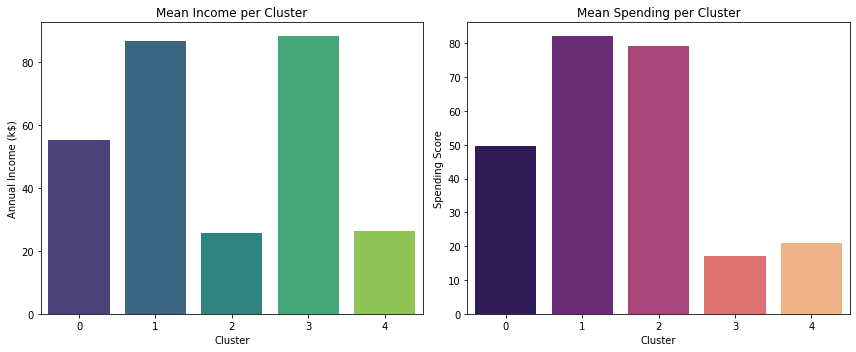


Cluster Personas:
   cluster  count  Annual Income (k$)  Spending Score (1-100)  \
0        0     81               55.30                   49.52   
1        1     39               86.54                   82.13   
2        2     22               25.73                   79.36   
3        3     35               88.20                   17.11   
4        4     23               26.30                   20.91   

                 persona  
0  Cautious Middle Class  
1   Affluent Minimalists  
2      Frugal Low-Income  
3  Aspirational Spenders  
4        Luxury Shoppers  


In [18]:
# --- Extra Visualisation & Personas ---

# Bar chart: mean income & spending per cluster
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.barplot(data=cluster_summary, x='cluster', y='Annual Income (k$)', ax=axes[0], palette="viridis")
axes[0].set_title("Mean Income per Cluster")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Annual Income (k$)")

sns.barplot(data=cluster_summary, x='cluster', y='Spending Score (1-100)', ax=axes[1], palette="magma")
axes[1].set_title("Mean Spending per Cluster")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Spending Score")

plt.tight_layout()
plt.show()

# Define personas (based on your interpretation)
persona_map = {
    0: "Cautious Middle Class",
    1: "Affluent Minimalists",
    2: "Frugal Low-Income",
    3: "Aspirational Spenders",
    4: "Luxury Shoppers"
}

cluster_summary['persona'] = cluster_summary['cluster'].map(persona_map)

print("\nCluster Personas:")
print(cluster_summary[['cluster','count','Annual Income (k$)','Spending Score (1-100)','persona']])


---

## Final Conclusion
- **KMeans** successfully segments mall customers into 5 distinct, interpretable groups.  
- The results align with intuitive marketing personas (premium, cautious, budget spenders, low-value).  
- **DBSCAN** was less effective on this dataset, showing that **KMeans is the more appropriate choice** for this task.